---
# Group statistics of pRF overlap

The main difference with the `group_overlap.ipynb` is that the neighbouring vertices originate from the whole-brain fit; not for every run (saves clogging up of the figure). Additionally, I aim to average across the iterations of the pRF experiment, see if that boosts statistics while retaining the original results

v3: fitted with averaged iterations

In [10]:
%matplotlib inline

In [2]:
from linescanning import (
    utils,
    plotting,
    prf,
    dataset,
    glm,
    optimal,
    fitting
)

from datetime import datetime
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import io, stats
import pandas as pd
import pRFline
from pRFline.plotting import pRFSpread
from pRFline.utils import SubjectsDict, sort_posthoc,read_subject_data
import pingouin
import researchpy as rp
from joblib import Parallel, delayed
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
opj = os.path.join
opd = os.path.dirname

230123-09:31:05,365 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.8.2


---
# Set defaults

In [3]:
# set defaults
task        = "task-pRF"
base_dir    = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF"
prog_dir    = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline"
# design_dir  = opj(prog_dir, "data_lp3")
design_dir  = opj(base_dir, "derivatives", "prf")
fig_dir     = opj(prog_dir, "results")

if "_lp" in os.path.basename(design_dir):
    filter_strat = "lp"
    w_length = 11
    p_order = 3 
else:
    filter_strat = "hp"
    w_length = None
    p_order = None

In [4]:
verbose = False
fix_bold = True
model = "gauss"
fit_nbr = True
downsample = False
nbr_r2_thresh = 0.1

# fetch subject dictionary from pRFline.utils.SubjectsDict
subj_obj = SubjectsDict()
dict_data = subj_obj.dict_data
process_subjs = subj_obj.get_subjects()
process_subjs

['sub-001', 'sub-002', 'sub-003', 'sub-005', 'sub-007', 'sub-008', 'sub-009']

---
# Main data parser

In [7]:
# full_dict = {}
# n_jobs = len(process_subjs)
# dd = Parallel(n_jobs=n_jobs,verbose=False)(
#     delayed(read_subject_data)(
#         subject,
#         deriv=opj(base_dir, "derivatives"),
#         model=model,
#         fix_bold=fix_bold,
#         verbose=True
#     )
#     for subject in process_subjs
# )

# for ix,subject in enumerate(process_subjs):
#     full_dict[subject] = dd[ix]

full_dict = {}
for subject in process_subjs:
    dd = read_subject_data(
        subject,
        deriv=opj(base_dir, "derivatives"),
        model=model,
        fix_bold=fix_bold,
        verbose=True
    )

    full_dict[subject] = dd


---------------------------------------------------------------------------------------------------
Dealing with sub-001 [2023/01/23 09:41:54]

-- linescanning --
Reading /data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-pRF_run-avg_desc-design_matrix.mat
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/code/prf_analysis.yml'
Fixing baseline at [0, 0]
Instantiate HRF with: [1, 1, 0] (fit=False)
Setting 'screen_distance_cm' to user-defined value: 196 (was: 210)
Setting 'grid_nr' to user-defined value: 40 (was: 20)
Setting 'rsq_threshold' to user-defined value: 0 (was: 0.1)
Using constraint(s): ['tc', 'tc']
Reading /data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-pRF_run-avg_vox-all_model-gauss_stage-iter_desc-prf_params.pkl
Reading settings from '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-pRF_run-avg_vox-all_model

---
# Main summary plot

Contains:

- row of subject-specific plots in visual space with the EPI-runs (grey circles), average EPI (black circle) and the average line pRF across the ribbon (subject-specific color)
- plot of normalized pRFs for all subjects
- r2 for various flavours (e.g., average EPI, EPI-runs, average line)
- Distance to average EPI (from EPI runs, 2mm away, 4mm away, 6mm away and the average line pRF)

In [8]:
colors=["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])

subjects = list(dict_data.keys())
cmap_subj = "Set2"
sub_colors = sns.color_palette(cmap_subj, len(subjects))

In [9]:
# figure settings
fig = plt.figure(figsize=(24,10))
subfigs = fig.subfigures(nrows=2, height_ratios=[0.5,1])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=5, 
    gridspec_kw={
        'width_ratios': [0.5,0.2,0.6,0.05,0.05], 
        'wspace': 0.4})

---
## IF YOU DON'T SEE FIGURE EXAMPLE, RUN THE FIRST CELL OF THE NOTEBOOK AGAIN (`%matplotlib inline`) BEFORE PROCEEDING
---

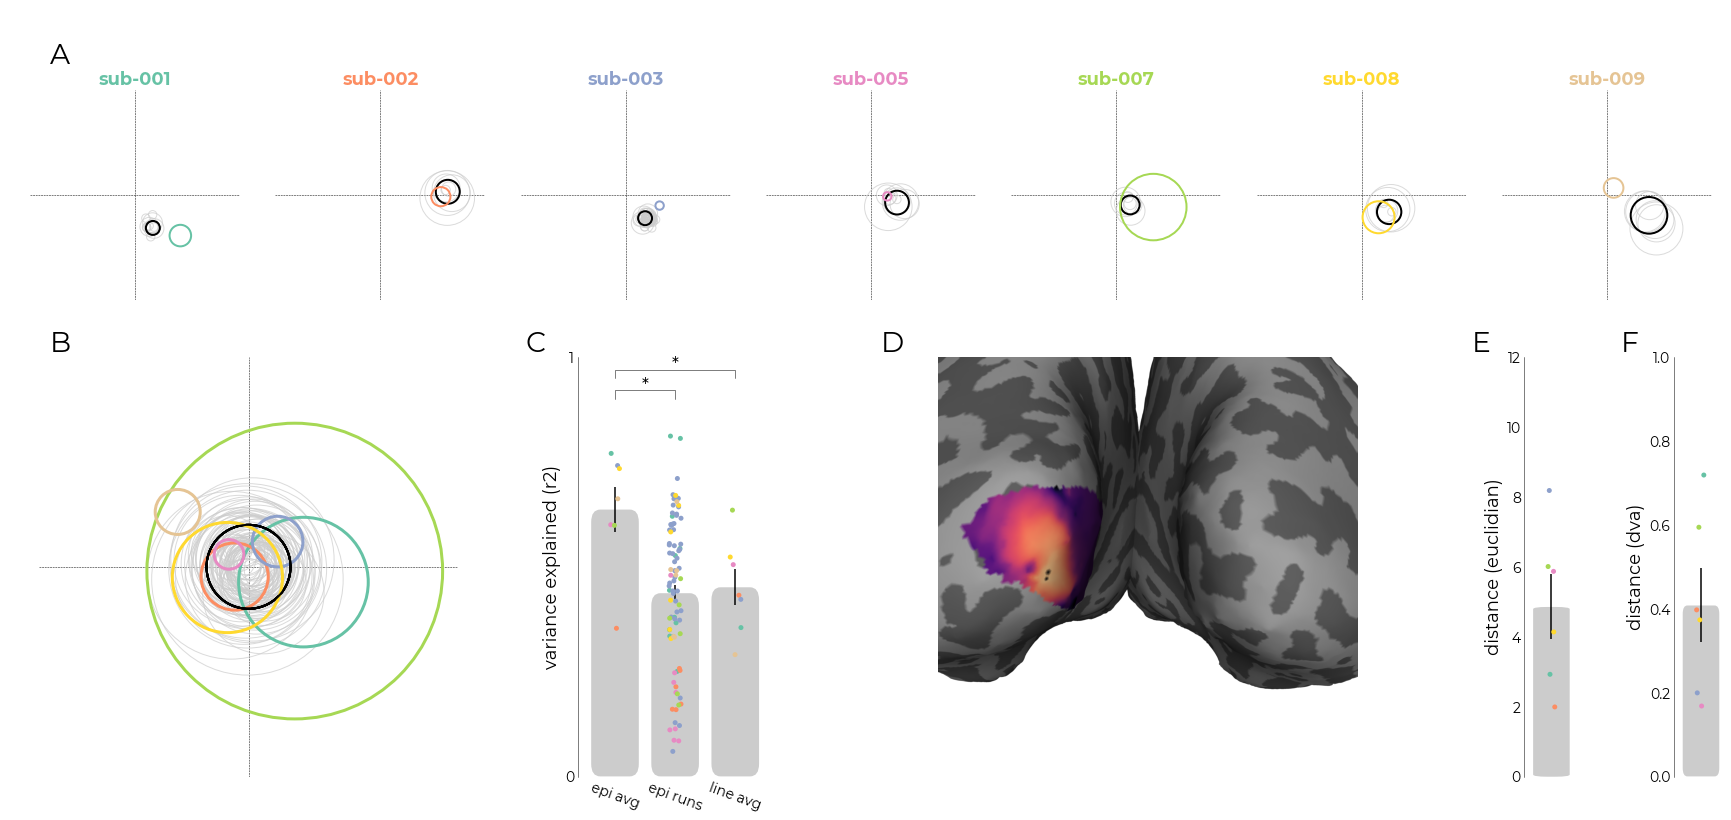

In [16]:
# figure settings
fig = plt.figure(figsize=(24,10))
subfigs = fig.subfigures(nrows=2, height_ratios=[0.5,1])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=5, 
    gridspec_kw={
        'width_ratios': [0.5,0.2,0.6,0.05,0.05], 
        'wspace': 0.4})

# axis for pRF overlap plot
axs = axs_avg[0]

r2s = {}
for ii in ["subject","r2","acq","name"]:
    r2s[ii] = []

for ix,sub in enumerate(process_subjs):

    ax_ = axs_subj[ix]

    run_obj = full_dict[sub]['wb']['runs']
    avg_obj = full_dict[sub]['wb']['avg']
    for run in range(run_obj.data.shape[0]):
        # get parameters from individual runs 
        pars,_,_,_ = run_obj.plot_vox(
            vox_nr=run,
            model=run_obj.model,
            stage='iter',
            make_figure=False
        )

        if pars[-1] != 0:
            # get parameters from average
            avg_pars,_,_,_ = avg_obj.plot_vox(
                vox_nr=subj_obj.get_target(sub),
                model=avg_obj.model,
                stage='iter',
                make_figure=False
            )

            # append r2 to dictionary
            r2s["r2"].append(pars[-1])
            r2s["subject"].append(sub)
            r2s["name"].append("epi runs")
            r2s["acq"].append(1)

            # plot normalized pRF
            run_norm = prf.normalize_prf(avg_pars,pars)
            
            # find x/y of max pRF
            center = (run_norm[0],run_norm[1])
            circ2 = plt.Circle(
                center,
                run_norm[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)
        
            axs.add_artist(circ2)

            # add non-normalized to subject specific axis
            circ_run_subj = plt.Circle(
                (pars[0],pars[1]),
                pars[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)

            ax_.add_artist(circ_run_subj)            
            
    else:
        r2s["r2"].append(getattr(avg_obj, f"{avg_obj.model}_iter")[subj_obj.get_target(sub),-1])
        r2s["subject"].append(sub)
        r2s["name"].append("epi avg")
        r2s["acq"].append(0)

        if ix == 0:

            # create visual field delineation, plot on subject specific axis & average
            plotting.LazyPRF(
                np.zeros((500,500)), 
                [-5,5],
                ax=axs,
                cross_color="k",
                edge_color=None,
                shrink_factor=0.9,
                cmap=cmap1,
                vf_only=True)

        # draw empty visual field for subject
        plotting.LazyPRF(
            np.zeros((500,500)), 
            [-5,5],
            ax=ax_,
            cross_color="k",
            edge_color=None,
            shrink_factor=0.9,
            cmap=cmap1,
            vf_only=True)

line_df = {}
for ii in ["subject","distance"]:
    line_df[ii] = []

for ix,sub in enumerate(process_subjs):

    # get parameters from average
    run_obj = full_dict[sub]['wb']['runs']
    avg_obj = full_dict[sub]['wb']['avg']    
    
    avg_pars,_,_,_ = avg_obj.plot_vox(
        vox_nr=subj_obj.get_target(sub),
        model=avg_obj.model,
        stage='iter',
        make_figure=False
    )

    circ_avg = plt.Circle(
        (0,0),
        1,
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    axs.add_artist(circ_avg)

    # add average line-scanning
    avg_line = full_dict[sub]['lines']["avg"]
    l_pars,_,_,_ = avg_line.plot_vox(
        model=avg_line.model,
        stage='iter',
        make_figure=False
    )

    # plot normalized pRF
    line_norm = prf.normalize_prf(avg_pars,l_pars)

    # find x/y of max pRF
    center = (line_norm[0],line_norm[1])
    circ3 = plt.Circle(
        center,
        line_norm[2],
        ec=sub_colors[ix],
        fill=False,
        lw=3)

    axs.add_artist(circ3)

    # add to subject specific axis
    sub_epi = plt.Circle(
        (avg_pars[0],avg_pars[1]),
        avg_pars[2],
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    sub_line = plt.Circle(
        (l_pars[0],l_pars[1]),
        l_pars[2],
        ec=sub_colors[ix],
        fill=False,
        lw=2)

    axs_subj[ix].add_artist(sub_epi)    
    axs_subj[ix].add_artist(sub_line)

    # axs.annotate(sub, xy=center, fontsize=12, ha="center")
    axs_subj[ix].set_title(sub, fontsize=18, color=sub_colors[ix], fontweight="bold")
 
    r2s["r2"].append(l_pars[-1])
    r2s["subject"].append(sub)
    r2s["name"].append("line avg")
    r2s["acq"].append(2)

    # get line_distance
    line_dist = prf.distance_centers(avg_pars, l_pars)/avg_pars[2]
    line_df["subject"].append(sub)
    line_df["distance"].append(line_dist)

# make dataframe
df_r2 = pd.DataFrame(r2s)
df_line = pd.DataFrame(line_df)

r2_axs = axs_avg[1]
pl = plotting.LazyBar(
    data=df_r2.sort_values(['acq','subject']),
    x="name",
    y="r2",
    sns_ori="v",
    sns_rot=-20,
    sns_offset=5,
    axs=r2_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    points_cmap=cmap_subj,
    points_hue="subject",    
    y_label2="variance explained (r2)",
    lim=[0,1],
    ticks=[0,1],
    fancy=True,
    trim_bottom=True
)

# FDR-corrected post hocs with Cohen's D effect size
posthoc = pingouin.pairwise_tests(
    data=df_r2, 
    dv='r2', 
    between='name', 
    parametric=True, 
    padjust='fdr_bh', 
    effsize='cohen')

minmax = list(r2_axs.get_ylim())
y_pos = 0.95
conditions = np.unique(pl.data["name"].values)

posthoc_sorted = sort_posthoc(posthoc)
for contr in range(posthoc_sorted.shape[0]):
    if posthoc_sorted["p-corr"].iloc[contr] < 0.05:
        
        txt = "*"
        style = None

        # read indices from output dataframe and conditions
        A = posthoc_sorted["A"].iloc[contr]
        B = posthoc_sorted["B"].iloc[contr]

        x1 = np.where(conditions == A)[0][0]
        x2 = np.where(conditions == B)[0][0]

        diff = minmax[1]-minmax[0]
        m = minmax[1]
        y, h, col =  (diff*y_pos)+minmax[0], diff*0.02, 'k'
        r2_axs.plot(
            [x1,x1,x2,x2], 
            [y,y+h,y+h,y], 
            lw=pl.tick_width, 
            c=col)

        r2_axs.text(
            (x1+x2)*.5, 
            y+h*0.5, 
            txt, 
            ha='center', 
            va='bottom', 
            color=col,
            fontsize=pl.font_size,
            style=style)

        # make subsequent bar lower than first
        y_pos -= 0.05

geod_axs = axs_avg[2]
im = imageio.imread(opj(fig_dir, "sub-002", f"sub-002_model-{model}_smooth-true_kernel-1_iter-1_desc-distance.png"))
geod_axs.imshow(im) #[2000:,:2000,:])
geod_axs.axis('off')

df_surf = pd.read_csv(opj(fig_dir, f"sub-all_model-{model}_smooth-true_kernel-1_iter-1_desc-dist_on_surf.csv"), index_col=0)
df_surf = utils.select_from_df(df_surf, expression="subject != sub-009")
for ix,par in enumerate(["euclidian","dva"]):

    if par == "euclidian":
        y_lim = [0,12]
        rdn = 0.3
    else:
        y_lim = [0,1]
        rdn = 0.1
    
    ax = axs_avg[ix+3]
    plotting.LazyBar(
        data=df_surf,
        x="ix",
        y=par,
        sns_ori="v",
        axs=ax,
        sns_offset=4,
        color="#cccccc",
        add_points=True,
        points_cmap="Set2",
        points_hue="subject",    
        y_label2=f"distance ({par})",
        fancy=True,
        fancy_rounding=rdn,
        lim=y_lim,
        trim_bottom=True
    )

plt.tight_layout()

# annotate axes
dist_from_x0 = 1/(fig.get_size_inches()*fig.dpi)[0]*50
axs_subj[0].annotate("A", (dist_from_x0,1.05), fontsize=28, xycoords="figure fraction")
axs_avg[0].annotate("B", (dist_from_x0,0.65), fontsize=28, xycoords="figure fraction")

# do the middle axes a bit nicer; move annotation X% of full figure width away from axis
pos1 = fig.axes[-4].get_position().x0
set_x1 = pos1-dist_from_x0
pos2 = fig.axes[-3].get_position().x0
set_x2 = pos2-dist_from_x0
pos3 = fig.axes[-2].get_position().x0
set_x3 = pos3-dist_from_x0
pos4 = fig.axes[-1].get_position().x0
set_x4 = pos4-dist_from_x0

axs_avg[1].annotate("C", (set_x1,0.65), fontsize=28, xycoords="figure fraction")
axs_avg[2].annotate("D", (set_x2,0.65), fontsize=28, xycoords="figure fraction")
axs_avg[3].annotate("E", (set_x3,0.65), fontsize=28, xycoords="figure fraction")
axs_avg[4].annotate("F", (set_x4,0.65), fontsize=28, xycoords="figure fraction")

sns.despine(bottom=True,ax=r2_axs)
plt.show()
# fname = opj(fig_dir, f"sub-all_model-{model}_desc-main_figure3")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )
# posthoc

---
# Subject average fits

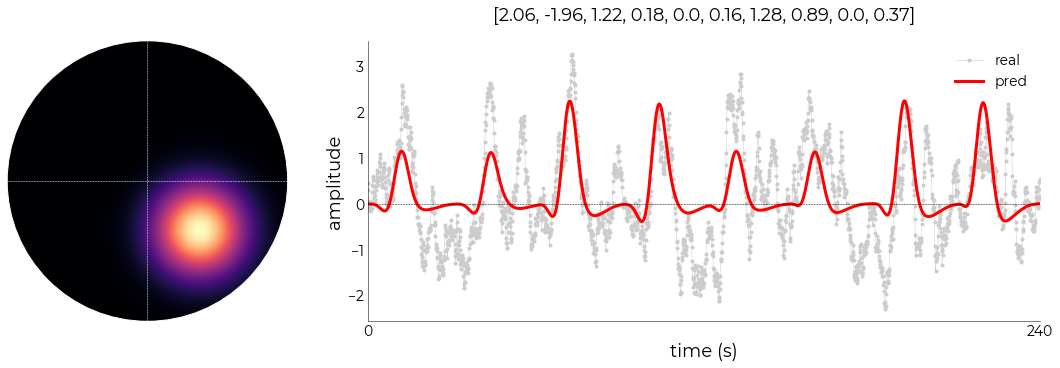

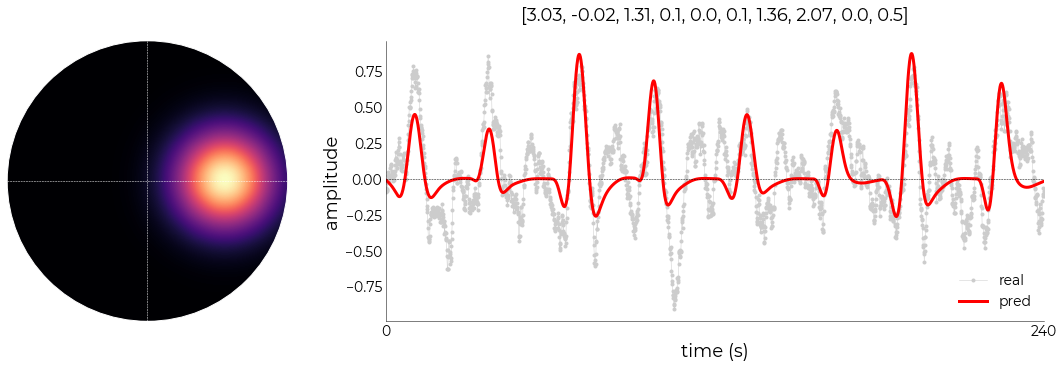

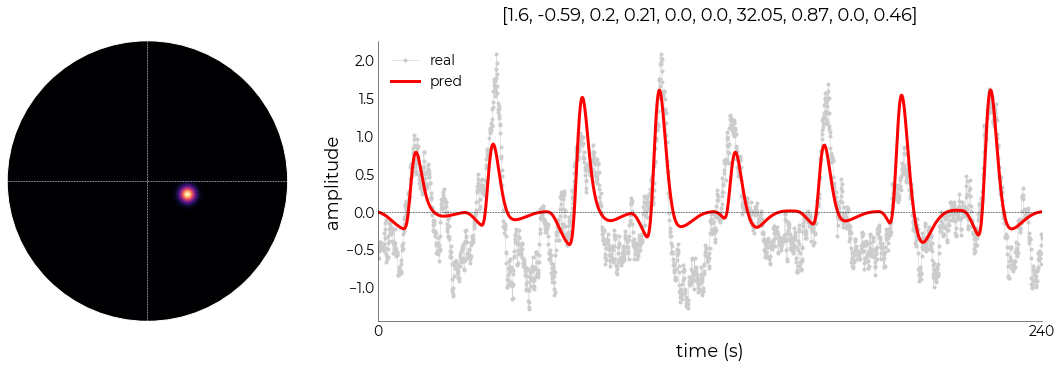

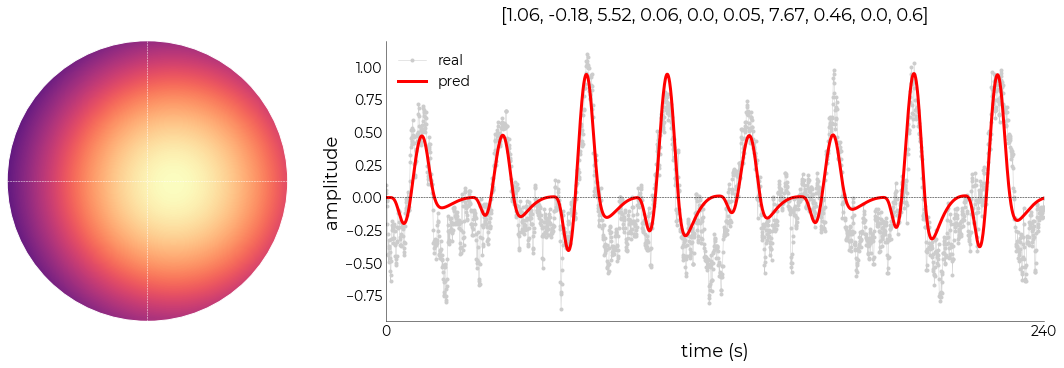

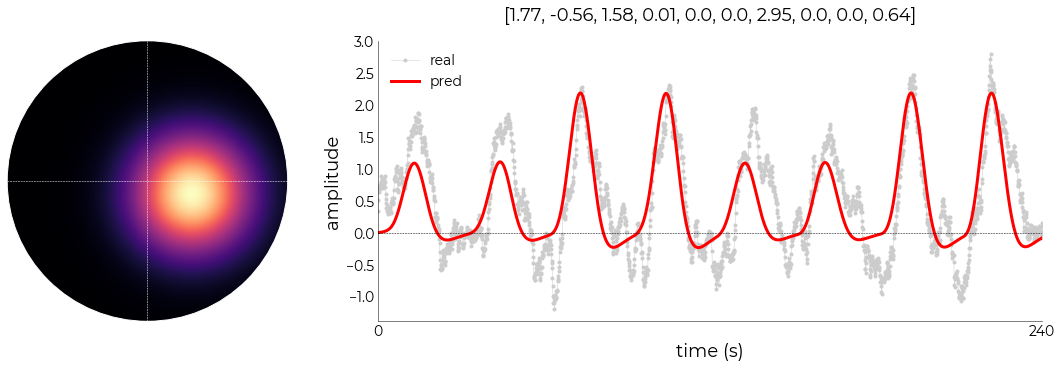

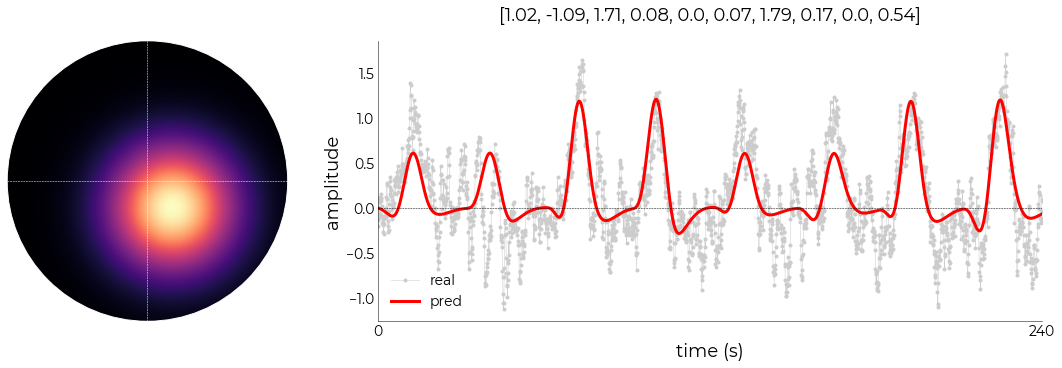

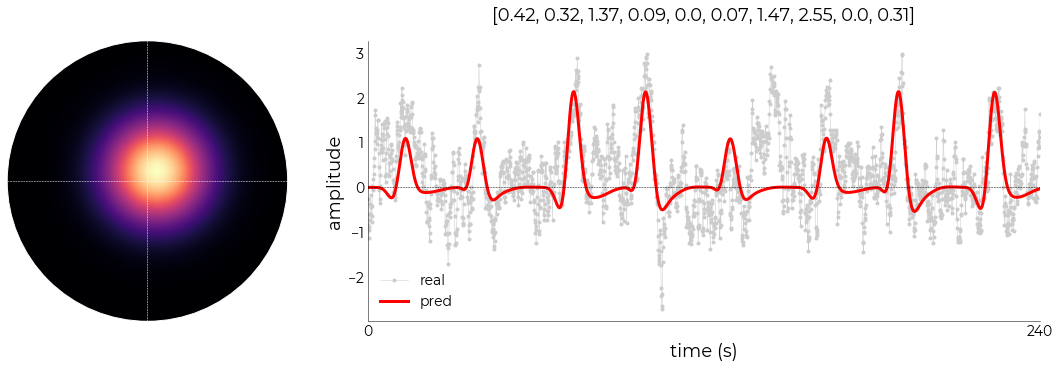

In [55]:
for ii in process_subjs:
    _,_,tc_p,pred_p = full_dict[ii]["lines"]["avg"].plot_vox(
        model=model,
        title="pars"
    )

---
# Magnitude pial/wm timecourse comparison

In [ ]:
t_s = "sub-003"
_,_,tc_p,pred_p = full_dict[t_s]["lines"]["ribbon"].plot_vox(
    vox_nr=0,
    model=model,
    title="pars"
)

_,_,tc_w,pred_w = full_dict[t_s]["lines"]["ribbon"].plot_vox(
    vox_nr=-1,
    model=model,
    title="pars"
)

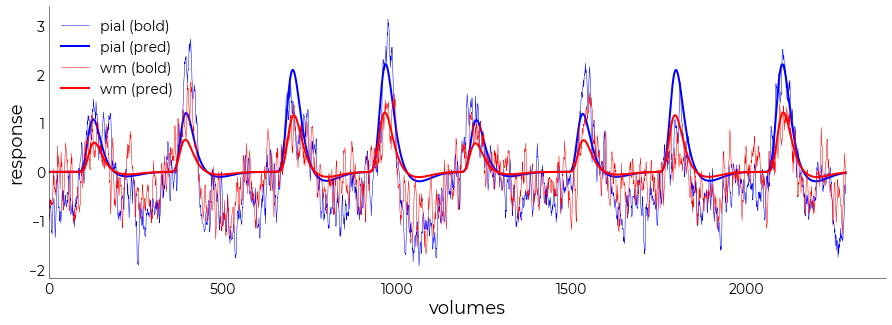

In [13]:
plotting.LazyPlot(
    [tc_p,pred_p,tc_w,pred_w],
    line_width=[0.5,2,0.5,2],
    # markers=[".",None,".",None],
    color=["b","b","r","r"],
    figsize=(15,5),
    x_label="volumes",
    y_label="response",
    labels=[
        "pial (bold)",
        "pial (pred)",
        "wm (bold)",
        "wm (pred)"]
)

---
# Difference-of-gaussian

In [76]:
subj = "sub-009"
deriv = opj(base_dir, "derivatives")
ses = subj_obj.get_session(subj)

prf_dir = opj(
    deriv, 
    "prf",
    subj, 
    f"ses-{ses}")

subj_ = {}

dm_f = opj(prf_dir, f"{subj}_ses-{ses}_task-pRF_run-avg_desc-design_matrix.mat")
dm_ = prf.read_par_file(dm_f)
mm = "dog"
for tt in ["avg","ribbon"]:
    input_data = prf.read_par_file(opj(os.path.dirname(dm_f), f"{subj}_ses-{ses}_task-pRF_run-avg_vox-{tt}_desc-data.npy"))

    obj_ = prf.pRFmodelFitting(
        input_data.T,
        design_matrix=dm_,
        model=mm,
        TR=0.105,
        fix_bold_baseline=fix_bold,
        verbose=False,
        rsq_threshold=0,
        screen_distance_cm=196,
        grid_nr=40,
        write_files=True,
        save_grid=False,
        output_dir=prf_dir,
        output_base=f"{subject}_ses-{ses}_task-pRF_run-avg_vox-{tt}"
    )

    pars_file = opj(obj_.output_dir, f"{obj_.output_base}_model-{mm}_stage-iter_desc-prf_params.pkl")
    obj_.load_params(
        pars_file, 
        model=mm, 
        stage="iter")

    subj_[tt] = obj_

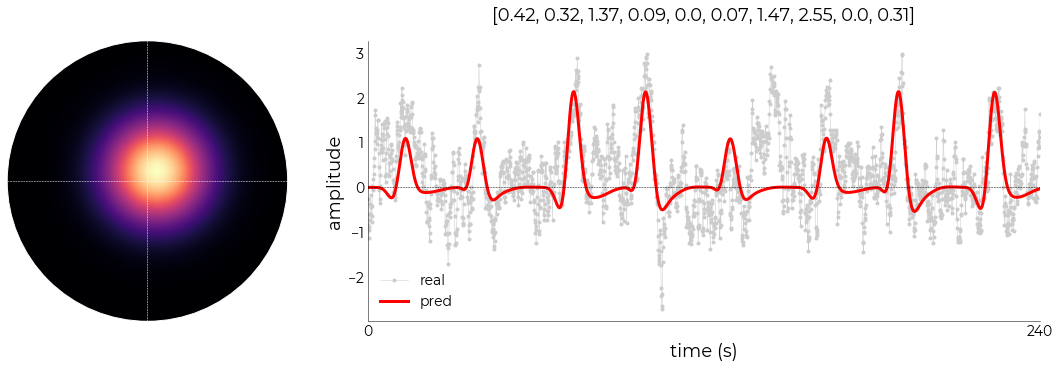

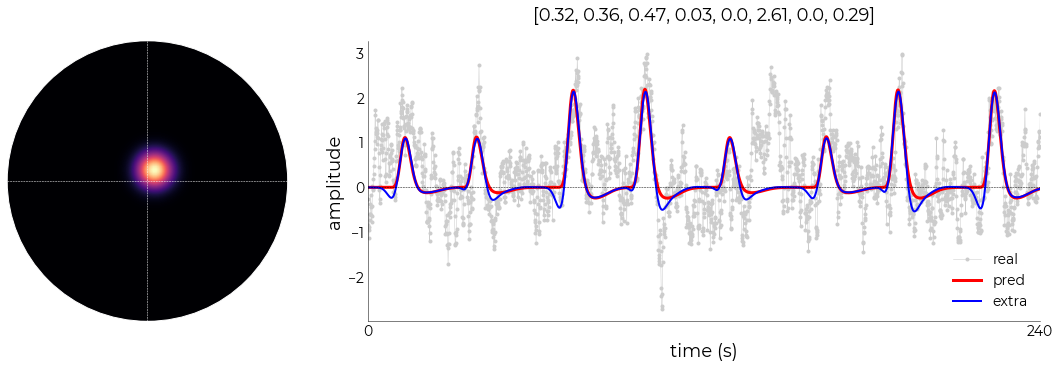

In [83]:
pars_dog,_,_,pred_dog = subj_["avg"].plot_vox(
    model="dog",
    title="pars"
)

pars_gauss,_,_,_ = full_dict[subj]["lines"]["avg"].plot_vox(
    model=model,
    title="pars",
    add_tc=pred_dog
)

In [82]:
print(f"Gauss:\t{pars_gauss}")
print(f"DoG:\t{pars_dog}")

Gauss:	[0.32293952 0.3555024  0.46777163 0.03417484 0.         2.60669181
 0.         0.29081499]
DoG:	[0.41684903 0.31530225 1.37179006 0.08607933 0.         0.07379284
 1.46722383 2.54918777 0.         0.30761046]


---
# Magnitude across depth with LMM

In [14]:
# length of HRF window
hrf_length_s = 30
hrf_length_tr = int(hrf_length_s/0.105)

# stimulus duration
stim_dur_s = 1
stim_dur_tr = int(stim_dur_s/0.105)

normalize = False

# csv
fname = opj(fig_dir, "magnitude_profiles3.csv")
if not os.path.exists(fname):
    hrf_design = np.zeros(())
    hrfs = []

    for ix,sub in enumerate(subjects):
    # for ix,sub in enumerate(["sub-001"]):

        print(f"Dealing with {sub}")

        sub_hrfs = []
        fit_obj = full_dict[sub]["lines"]["all"]

        vox_range = np.arange(*subj_obj.get_ribbon(sub))
        pars = getattr(fit_obj, f"{model}_iter").copy()[vox_range,:]
        if sub == "sub-002":
            vox_range = vox_range[:-1]
            
        # elif sub == "sub-003" or sub == "sub-007" or sub == "sub-005":
        #     vox_range = vox_range[:-1]

        # loop through voxel parameters
        for ii,vox in enumerate(vox_range):
            
            # get the HRF prediction
            _,_,_,hrf = fit_obj.plot_vox(
                vox_nr=vox,
                model=model,
                make_figure=False)
            
            ss = np.sum(hrf)
            is_nan = np.isnan(ss)
            # if is_nan or np.all(hrf==0):
            #     print(f" idx {vox} has NaNs or is fully zero")
            # else:
            # fetch first peak
            hrf = hrf[:hrf_length_tr,...]
            
            # create time axis
            xx = list(np.arange(0,hrf.shape[0])*fit_obj.TR)

            # create dataframe
            df_hrf = pd.DataFrame(hrf, columns=["hrf"])
            df_hrf["subject"],df_hrf["t"],df_hrf["depth"] = sub,xx,ii

            sub_hrfs.append(pd.DataFrame(df_hrf))
            
        # append subject-specific HRFs
        hrfs.append(pd.concat(sub_hrfs))

    # concatenate into single dataframe
    hrf_df = pd.concat(hrfs).set_index(["subject","t","depth"])

    print(f"Writing '{fname}'")
    hrf_df.to_csv(fname)
    print("Done")
else:
    print(f"Reading '{fname}'")
    hrf_df = pd.read_csv(fname).set_index(["subject","t","depth"])
    
hrf_df


Dealing with sub-001
Dealing with sub-002
Dealing with sub-003
Dealing with sub-005
Dealing with sub-007
Dealing with sub-008
Dealing with sub-009
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/results/magnitude_profiles3.csv'
Done


hrf
subject t      depth              
sub-001 0.000  0     -1.154513e-17
        0.105  0     -2.309026e-17
        0.210  0     -1.616318e-16
        0.315  0      4.618051e-17
        0.420  0     -3.463538e-17
...                            ...
sub-009 29.400 8     -1.036574e-02
        29.505 8     -9.599937e-03
        29.610 8     -8.867514e-03
        29.715 8     -8.167745e-03
        29.820 8     -7.499878e-03

[13395 rows x 1 columns]

Dealing with sub-001
Dealing with sub-002
Dealing with sub-003
Dealing with sub-005
Dealing with sub-007
Dealing with sub-008
Dealing with sub-009


mag      fwhm        ttp
subject level depth                                   
sub-001 0     0.000000   0.991429  5.138085  12.032632
        1     16.666667  0.993076  5.668260  12.137263
        2     33.333333  1.102241  5.473939  11.928000
        3     50.000000  1.160126  5.576976  12.032632
        4     66.666667  1.337638  5.505923  12.032632

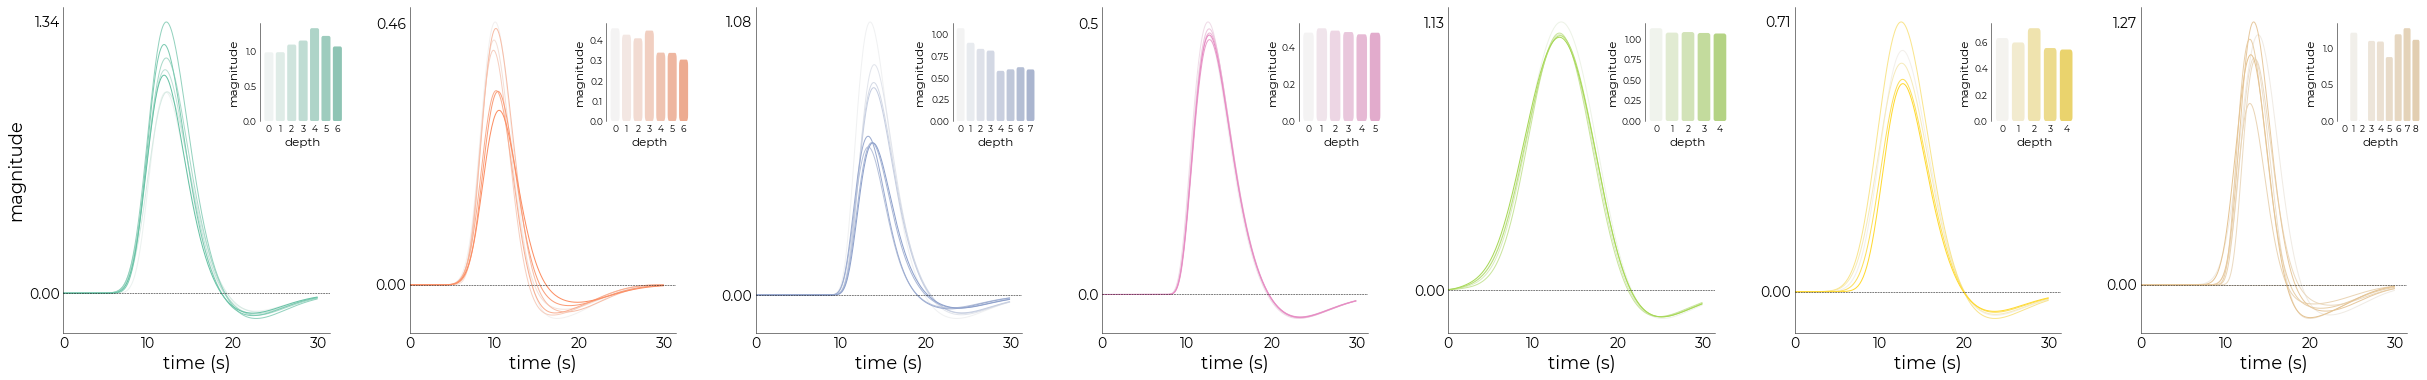

In [15]:
fig,axs = plt.subplots(ncols=len(dict_data),figsize=(6*len(dict_data),6), gridspec_kw={'wspace': 0.3})

plot_mag = True
plot_ttp = True
plot_fwhm = False

df_mag = {}
for ii in ["subject","level","depth","mag","fwhm","ttp"]:
    df_mag[ii] = []

for ix,sub in enumerate(subjects):
    
    # get the pRF-object containing estimates across depth
    if "all" in list(full_dict[sub]["lines"].keys()):

        print(f"Dealing with {sub}")
        
        fit_obj = full_dict[sub]["lines"]["all"]

        # get subject-specific HRFs from HRF-dataframe  
        sub_hrf = utils.select_from_df(hrf_df, expression=f"subject = {sub}")

        # parse them into list depending on the number of voxels in estimates
        depths = np.unique(sub_hrf.reset_index()["depth"].values)
        depths_pc = np.arange(0,depths.shape[0])/(depths.shape[0]-1)*100

        hrf_list = []
        for ii in depths:
            dd = utils.select_from_df(sub_hrf, expression=f"depth = {ii}")['hrf'].values
            
            if not np.isnan(dd.sum()) or not np.all(dd==0):
                hrf_list.append(dd)                

                df_mag["subject"].append(sub)
                df_mag["depth"].append(depths_pc[ii])
                df_mag["level"].append(ii)

        # get subject specific color palette
        colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", len(hrf_list))
        y_ticks = None
        trim_left = False
        if ix == 0:
            if normalize:
                trim_left = True

            y_lbl = "magnitude"
        else:
            y_lbl = None

        # create time axis
        time_axis = list(np.arange(0,hrf_list[0].shape[0])*fit_obj.TR)

        # plot
        y_ticks = [0,round(np.amax(np.array(hrf_list)),2)]
        plotting.LazyPlot(
            hrf_list,
            axs=axs[ix],
            xx=time_axis,
            x_label="time (s)",
            y_label=y_lbl,
            cmap=colors,
            # x_lim=[0,25],
            # x_ticks=np.arange(0,30,5),
            y_ticks=y_ticks,
            add_hline=0,
            trim_left=trim_left
        )

        # # add annotation where stim was ON; timings where the same across subjects/depths so doesn't matter which hrf_dm we use here
        # stim_tp = np.where((np.sum(hrf_dm, axis=(0, 1)) != 0))[0]
        # axs[ix].axvspan(time_axis[stim_tp[0]],time_axis[stim_tp[-1]], color="#cccccc", alpha=0.5) #, ymin=0, ymax=0.05)
        
        # add time-to-peak across the ribbon as inset-axis
        tcs = np.array(hrf_list)
        peak_positions = (np.argmax(tcs, axis=1)/tcs.shape[-1])*xx[-1]

        # FWHM
        y_fwhm = np.zeros((len(hrf_list)))
        for hrf_ix,hrf in enumerate(hrf_list):
            try:
                fwhm = fitting.FWHM(time_axis, hrf).fwhm
            except:
                fwhm = 0
            y_fwhm[hrf_ix] = fwhm

        if plot_mag or plot_ttp or plot_fwhm:
            ax2 = axs[ix].inset_axes([0.75, 0.65, 0.3, 0.3])

        # get magnitudes
        mag = np.array([np.amax(i) for i in hrf_list])

        for ix,(par,var) in enumerate(zip(["mag","fwhm","ttp"],[mag,y_fwhm,peak_positions])):
            for it_ix,it in enumerate(var):
                df_mag[par].append(it)
        
        # decide plot properties depending on which type to put on the inset axis
        if plot_mag:
            plot_ttp = False
            plot_fwhm = False
            y_ax = mag
            ori = "v"
            y_lab = "magnitude"
            x_lab = "depth"

        if plot_ttp:
            plot_fwhm = False
            y_ax = peak_positions
            ori = "h"
            y_lab = "depth"
            x_lab = "time-to-peak (s)"

        if plot_fwhm:
            y_ax = y_fwhm
            ori = "v"
            y_lab = "FWHM"
            x_lab = "depth"            

        plotting.LazyBar(
            x=np.arange(0,len(hrf_list)),
            y=y_ax,
            axs=ax2,
            label_size=9,
            font_size=12,
            palette=colors,
            sns_ori=ori,
            add_labels=True,
            y_label2=y_lab,
            x_label2=x_lab,
            alpha=0.8,
            fancy=True,
            sns_offset=3,
            trim_bottom=True)            

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_hrf")
if normalize:
    fname = f"{fname}_norm"

# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         # bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

df_mag = pd.DataFrame(df_mag).set_index(["subject","level","depth"])
df_mag.head()

In [16]:
lm_df = df_mag.reset_index()
lm_df.head()

,subject,level,depth,mag,fwhm,ttp
0,sub-001,0,0.000000,0.991429,5.138085,12.032632
1,sub-001,1,16.666667,0.993076,5.668260,12.137263
2,sub-001,2,33.333333,1.102241,5.473939,11.928000
3,sub-001,3,50.000000,1.160126,5.576976,12.032632
4,sub-001,4,66.666667,1.337638,5.505923,12.032632


- formula=`mag ~ depth + 1` means that you want to explain `mag` with `depth` and an intercept
- groups=`subject` means that you want random effect for all levels of `subject`
- re_formula=`~depth + 1` means that you want a random intercept and a random slope for `depth`


In [18]:
md = smf.mixedlm("mag ~ depth + 1", lm_df, groups="subject", re_formula="~depth + 1")

free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
    np.ones(2), np.eye(2)
)

mdf = md.fit(free=free, method=["lbfgs"])
print(mdf.summary())


           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   mag     
No. Observations:   47        Method:               REML    
No. Groups:         7         Scale:                0.0345  
Min. group size:    5         Log-Likelihood:       -31.7175
Max. group size:    9         Converged:            Yes     
Mean group size:    6.7                                     
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.737    0.131 5.608 0.000  0.479  0.994
depth               0.000    0.071 0.007 0.995 -0.139  0.140
subject Var         0.104    0.587                          
subject x depth Cov 0.000    0.000                          
depth Var           0.035                                   



In [21]:
rp.summary_cont(lm_df.groupby(["subject"])["mag"])

,N,Mean,SD,SE,95% Conf.,Interval
subject,,,,,,
sub-001,7,1.1266,0.1258,0.0476,1.0102,1.2430
sub-002,7,0.3920,0.0616,0.0233,0.3351,0.4490
sub-003,8,0.7580,0.1822,0.0644,0.6057,0.9103
sub-005,6,0.4840,0.0113,0.0046,0.4722,0.4958
sub-007,5,1.0889,0.0258,0.0116,1.0568,1.1210
sub-008,5,0.6089,0.0654,0.0292,0.5278,0.6901
sub-009,9,0.8721,0.5064,0.1688,0.4828,1.2614


### Assumption check

Linear mixed effect models have the same assumptions as the traditional standard linear regression model

#### Normality

One can check for normality of the residuals graphically, a formal statistical test, or a combination of the two. If the overal sample is large one should use both since as the sample size increases so does the power of the tests, meaning that the larger the sample size the smaller of a difference the formal statistical test will detect and a significant p-value will be provided.

First let's visualize the residuals with a kernal density estimate plot and Q-Q plot. 

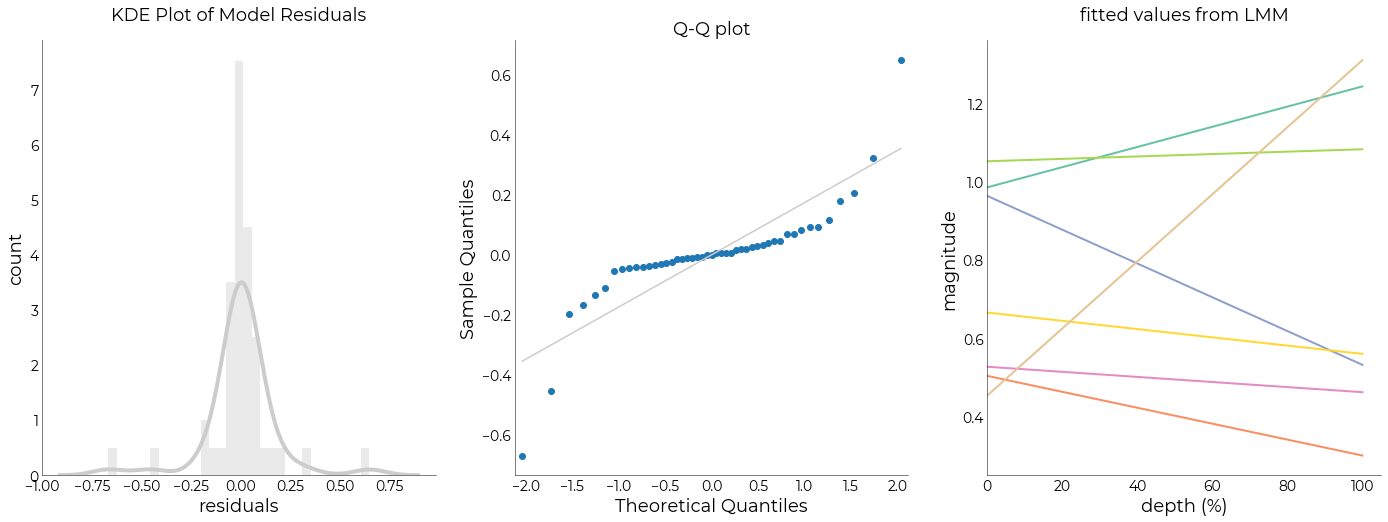

In [62]:
fig = plt.figure(figsize=(24,8))
gs = fig.add_gridspec(ncols=3)

ax1 = fig.add_subplot(gs[0])
pl = plotting.LazyHist(
    mdf.resid,
    axs=ax1,
    kde=True,
    hist=True,
    fill=False,
    title2="KDE Plot of Model Residuals",
    x_label2="residuals",
    y_label2="count",
    hist_kwargs={"alpha": 0.4},
    kde_kwargs={"linewidth": 4})

ax2 = fig.add_subplot(gs[1])
sm.qqplot(
    mdf.resid, 
    dist=stats.norm, 
    line='s', 
    ax=ax2,
    lw=4)

# update with LazyPlot aesthetics
ax2 = plotting.conform_ax_to_obj(
    ax2,
    pl, 
    title="Q-Q plot")

# change linecolor 
ax2.lines[1].set_color("#cccccc")

# plot fitted values
ax3 = fig.add_subplot(gs[2])
df_pred = pd.DataFrame(mdf.fittedvalues, columns=["pred_value"])
df_pred["subject"] = lm_df["subject"]
df_pred["depth"] = lm_df["depth"]

for sub_ix,subject in enumerate(subjects):
    data = utils.select_from_df(df_pred, expression=f"subject = {subject}")
    yy = data["pred_value"].values
    depth = data["depth"].values

    plotting.LazyPlot(
        yy,
        xx=depth,
        color=sub_colors[sub_ix],
        line_width=2,
        x_label="depth (%)",
        y_label="magnitude",
        title="fitted values from LMM",
        axs=ax3
    )


In [235]:
resid_df = pd.DataFrame(mdf.resid.values.copy(), columns=["residuals"])
resid_df["subject"] = lm_df["subject"]
resid_df["depth"] = lm_df["depth"]
resid_df.head()


,residuals,subject,depth
0,0.030962,sub-001,0.000000
1,-0.016207,sub-001,16.666667
2,0.044157,sub-001,33.333333
3,0.053235,sub-001,50.000000
4,0.181893,sub-001,66.666667


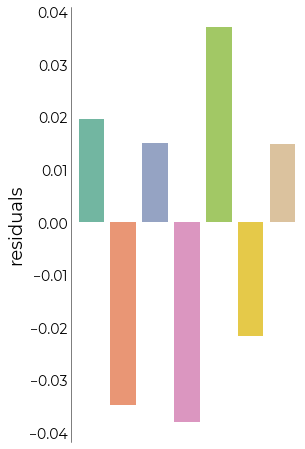

In [253]:
plotting.LazyBar(
    data=resid_df,
    x="subject",
    y="residuals",
    sns_ori="v",
    figsize=(4,8),
    sns_offset=4,
    cmap="Set2",
    y_label2=f"residuals",
    # fancy=True,
    # lim=y_lim,
    trim_bottom=True,
    error=None
)

The random intercept and random slope are only weakly correlated. So next we fit a model in which the two random effects are constrained to be uncorrelated:

In [ ]:
0.001 / (0.098 * 0.003) ** 0.5

0.058321184351980436

---
## Check positional stability

### Across ribbon

In [57]:
# initialize parameter df
params_depth =  []
params_depth_z =  []

for ix,sub in enumerate(subjects):

    # initialize subject specific parameter df
    sub_hrfs = []

    # get the pRF-object containing estimates across depth
    fit_obj = full_dict[sub]["lines"]["all"]
    
    # parse normalization parameters to dataframe
    vox_range = np.arange(*subj_obj.get_ribbon(sub))
    pars = getattr(fit_obj, f"{model}_iter").copy()[vox_range,:]
        
    df = prf.SizeResponse.parameters_to_df(pars, model=model)

    # get numerical colums for applying z-score. x/y/baselines will be NaN because they're all zero anyway
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_z = df[numeric_cols].apply(stats.zscore)
    
    # append depth indexer
    df["subject"] = sub
    df_z["subject"] = sub
    depth = np.arange(0,df_z.shape[0])/(df_z.shape[0]-1)*100
    if subj_obj.get_invert(sub):
        depth = depth[::-1]

    df["depth"] = depth
    df_z["depth"] = depth
    df["voxels"] = vox_range
    df_z["voxels"] = vox_range
    df = df.sort_values("depth")
    df_z = df_z.sort_values("depth")
    params_depth.append(df)
    params_depth_z.append(df_z)
    
params_depth = pd.concat(params_depth)
params_depth = params_depth.set_index(["subject","depth","voxels"])

params_depth_z = pd.concat(params_depth_z)
params_depth_z = params_depth_z.set_index(["subject","depth","voxels"])

params_depth.head()

x         y  prf_size  prf_ampl  bold_bsl  \
subject depth     voxels                                                     
sub-001 0.000000  359     2.019408 -1.881356  0.345443  0.068548       0.0   
        16.666667 360     1.979911 -1.923599  0.566408  0.028540       0.0   
        33.333333 361     2.064352 -1.985540  0.506034  0.038268       0.0   
        50.000000 362     2.138256 -1.902235  0.585886  0.030658       0.0   
        66.666667 363     2.269764 -1.865558  0.576267  0.036033       0.0   

                                r2       ecc     polar  
subject depth     voxels                                
sub-001 0.000000  359     0.309623  2.759983 -0.750022  
        16.666667 360     0.266944  2.760485 -0.770973  
        33.333333 361     0.259696  2.864248 -0.765940  
        50.000000 362     0.314916  2.861929 -0.727051  
        66.666667 363     0.439232  2.938050 -0.687963

Text(0.5, 0.98, 'stability position across depth')

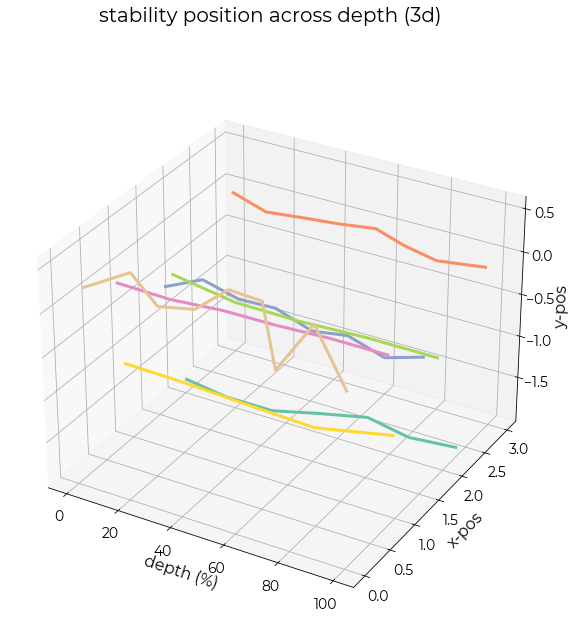

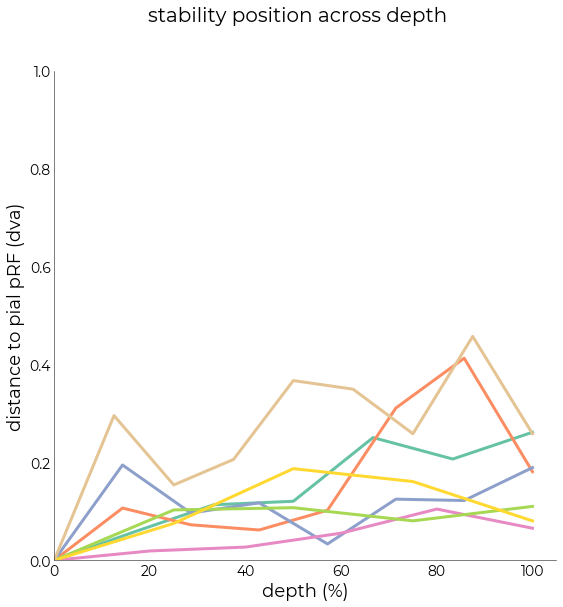

In [58]:
fig,ax1 = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

defs = plotting.Defaults()
df_diff = {}
for ii in ["subject","diff0","depth","voxels"]:
    df_diff[ii] = []

for sub_ix,sub in enumerate(subjects):
    data = utils.select_from_df(params_depth, expression=f"subject = {sub}")
    
    # parse into coordinates
    coordinates = list(zip(data.x, data.y))
    x, y = zip(*coordinates)

    # x axis
    depth_ax = data.reset_index().depth.values
    vox_ax = data.reset_index().voxels.values

    for c_ix,coord in enumerate(coordinates):
        diff = prf.distance_centers(coord,coordinates[0])

        # scatter is relative to pRF size (Hubel & Wiesel, 1974; Harvey & Dumoulin , 2011), so express differences as percentage of size?
        df_diff["subject"].append(sub)
        df_diff["diff0"].append(diff)
        df_diff["depth"].append(depth_ax[c_ix])
        df_diff["voxels"].append(vox_ax[c_ix])
        
    ax1.plot(depth_ax, x, y, color=sub_colors[sub_ix], lw=3)

ax1.set_xlabel("depth (%)", fontsize=defs.label_size+2)
ax1.set_ylabel("x-pos", fontsize=defs.label_size+2)
ax1.set_zlabel("y-pos", fontsize=defs.label_size+2)

ax1.tick_params(
    width=defs.tick_width, 
    length=defs.tick_length,
    labelsize=defs.label_size)
fig.suptitle("stability position across depth (3d)", fontsize=defs.font_size+2)

fig,ax2 = plt.subplots(figsize=(9,9))
df_diff = pd.DataFrame(df_diff)

for sub_ix,sub in enumerate(subjects):
    data = utils.select_from_df(df_diff, expression=f"subject = {sub}")

    x_data = data["depth"].values
    y_data = data["diff0"].values

    plotting.LazyPlot(
        y_data,
        xx=x_data,
        axs=ax2,
        color=sub_colors[sub_ix],
        line_width=3,
        x_label="depth (%)",
        y_label="distance to pial pRF (dva)",
        y_lim=[0,1]
    )

fig.suptitle("stability position across depth", fontsize=defs.font_size+2)

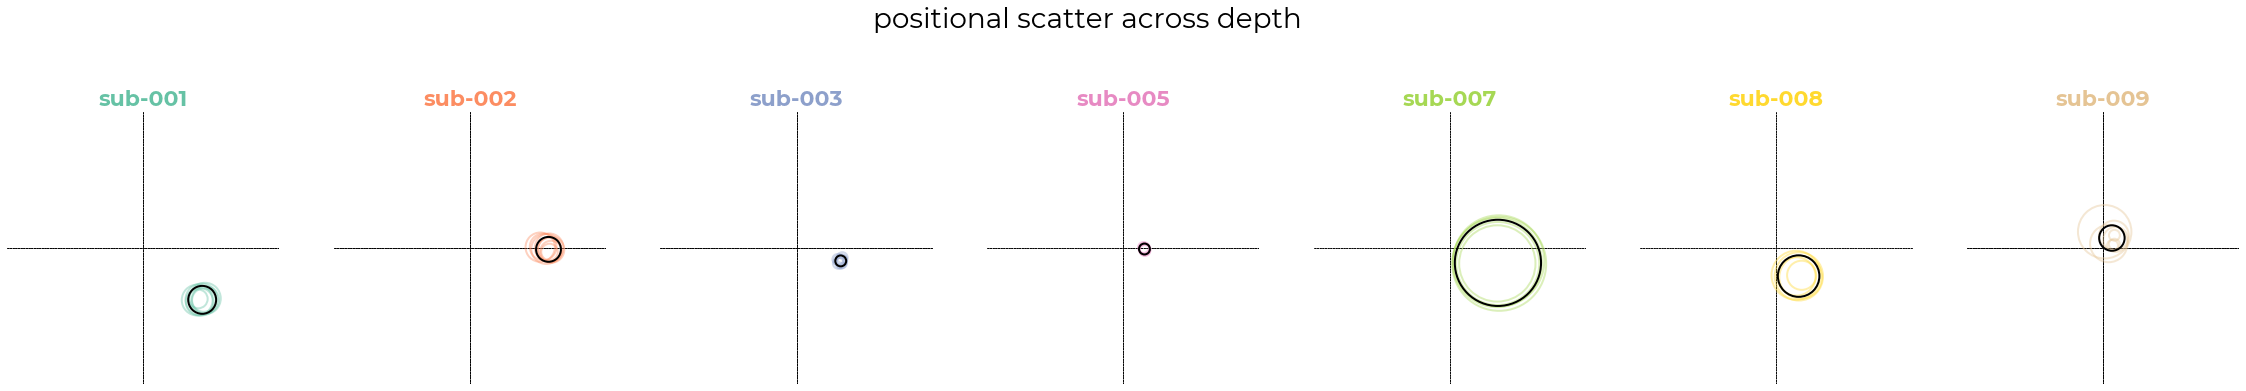

In [59]:
fig = plt.figure(figsize=(40,7))
gs = fig.add_gridspec(ncols=len(process_subjs))

for ix,subject in enumerate(process_subjs):

    rib_o = full_dict[subject]["lines"]["all"]

    sub_ax = fig.add_subplot(gs[ix])
    df = utils.select_from_df(
        params_depth, 
        expression=f"subject = {subject}")
    
    depths = df.reset_index().depth.values
    voxels = df.reset_index().voxels.values
    colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", depths.shape[0])
    for d_i,depth in enumerate(depths):
        cm = utils.make_binary_cm(colors[d_i])
        d_par = getattr(rib_o, f"{model}_iter")[voxels[d_i],:]
        d_pr = prf.make_prf(
            rib_o.prf_stim,
            mu_x=d_par[0],
            mu_y=d_par[1],
            size=d_par[2]
        )

        plotting.LazyPRF(
            np.zeros_like(d_pr),
            # d_pr,
            [-5,5],
            ax=sub_ax,
            cmap=cm,
            cross_color="k",
            edge_color=None,
            alpha=0.3
        )

        x,y,si = d_par[:3]
        d_line = plt.Circle(
            (x,y),
            si,
            ec=sub_colors[ix],
            fill=False,
            alpha=0.4,
            lw=2)
        sub_ax.add_artist(d_line)

    avg_o = full_dict[subject]["lines"]["avg"]
    x,y,si = getattr(avg_o, f"{model}_iter")[0,:3]
    sub_line = plt.Circle(
        (x,y),
        si,
        ec="k", #sub_colors[ix],
        fill=False,
        lw=2)

    sub_ax.add_artist(sub_line)
    sub_ax.set_title(subject, fontsize=22, color=sub_colors[ix], fontweight="bold")

fig.suptitle("positional scatter across depth", fontsize=28)
plt.show()

### Across line

In [60]:
# initialize parameter df
params_line =  []
params_line_z =  []

for ix,sub in enumerate(subjects):

    # get the pRF-object containing estimates across depth
    fit_obj = full_dict[sub]["lines"]["all"]
    
    # parse normalization parameters to dataframe
    pars = getattr(fit_obj, f"{model}_iter").copy()
    vox_range = np.arange(pars.shape[0])
        
    df = prf.SizeResponse.parameters_to_df(pars, model=model)

    # get numerical colums for applying z-score. x/y/baselines will be NaN because they're all zero anyway
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_z = df[numeric_cols].apply(stats.zscore)
    
    # append depth indexer
    df["subject"] = sub
    df_z["subject"] = sub

    df["voxels"] = vox_range
    df_z["voxels"] = vox_range
    params_line.append(df)
    params_line_z.append(df_z)
    
params_line = pd.concat(params_line)
params_line = params_line.set_index(["subject","voxels"])

params_line_z = pd.concat(params_line_z)
params_line_z = params_line_z.set_index(["subject","voxels"])

params_line.head()

x         y  prf_size  prf_ampl  bold_bsl        r2  \
subject voxels                                                              
sub-001 0       0.00000  0.000000  0.000000  0.000000       0.0  0.000000   
        1       1.38706 -3.057541  0.200003  0.031322       0.0  0.008535   
        2       0.00000  0.000000  0.000000  0.000000       0.0  0.000000   
        3       0.00000  0.000000  0.000000  0.000000       0.0  0.000000   
        4       0.00000  0.000000  0.000000  0.000000       0.0  0.000000   

                     ecc     polar  
subject voxels                      
sub-001 0       0.000000  0.000000  
        1       3.357453 -1.144909  
        2       0.000000  0.000000  
        3       0.000000  0.000000  
        4       0.000000  0.000000

In [91]:
diff_line = []

# for sub_ix,sub in enumerate(["sub-009"]):
for sub_ix,sub in enumerate(subjects):
    data = utils.select_from_df(params_line, expression=f"subject = {sub}")
    
    # initiate NaN array
    diff2avg = np.full(data.shape[0],-1, dtype=float)

    # parse into coordinates
    coordinates = list(zip(data.x, data.y))
    x, y = zip(*coordinates)

    # avg line
    avg_line = tuple(getattr(full_dict[sub]["lines"]["avg"], f"{model}_iter")[0,:2])

    # x axis
    vox_ax = data.reset_index().voxels.values

    for c_ix,coord in enumerate(coordinates):

        # scatter is relative to pRF size (Hubel & Wiesel, 1974; Harvey & Dumoulin , 2011), so express differences as percentage of size?
        if data["r2"].iloc[c_ix] > 0:
            diff = prf.distance_centers(coord,avg_line)
            # print(f"diff = {diff}")
            diff2avg[c_ix] = diff
    
    df = pd.DataFrame({
    "diff2avg": diff2avg,
    "voxels": vox_ax})
    
    df["subject"] = sub
    diff_line.append(df)

diff_line = pd.concat(diff_line).set_index(["subject", "voxels"])
diff_line.head()

diff2avg
subject voxels          
sub-001 0      -1.000000
        1       1.380723
        2      -1.000000
        3      -1.000000
        4      -1.000000

sub-001: (359, 366)
sub-002: (358, 366)
sub-003: (358, 366)
sub-005: (360, 366)
sub-007: (361, 366)
sub-008: (359, 364)
sub-009: (358, 367)


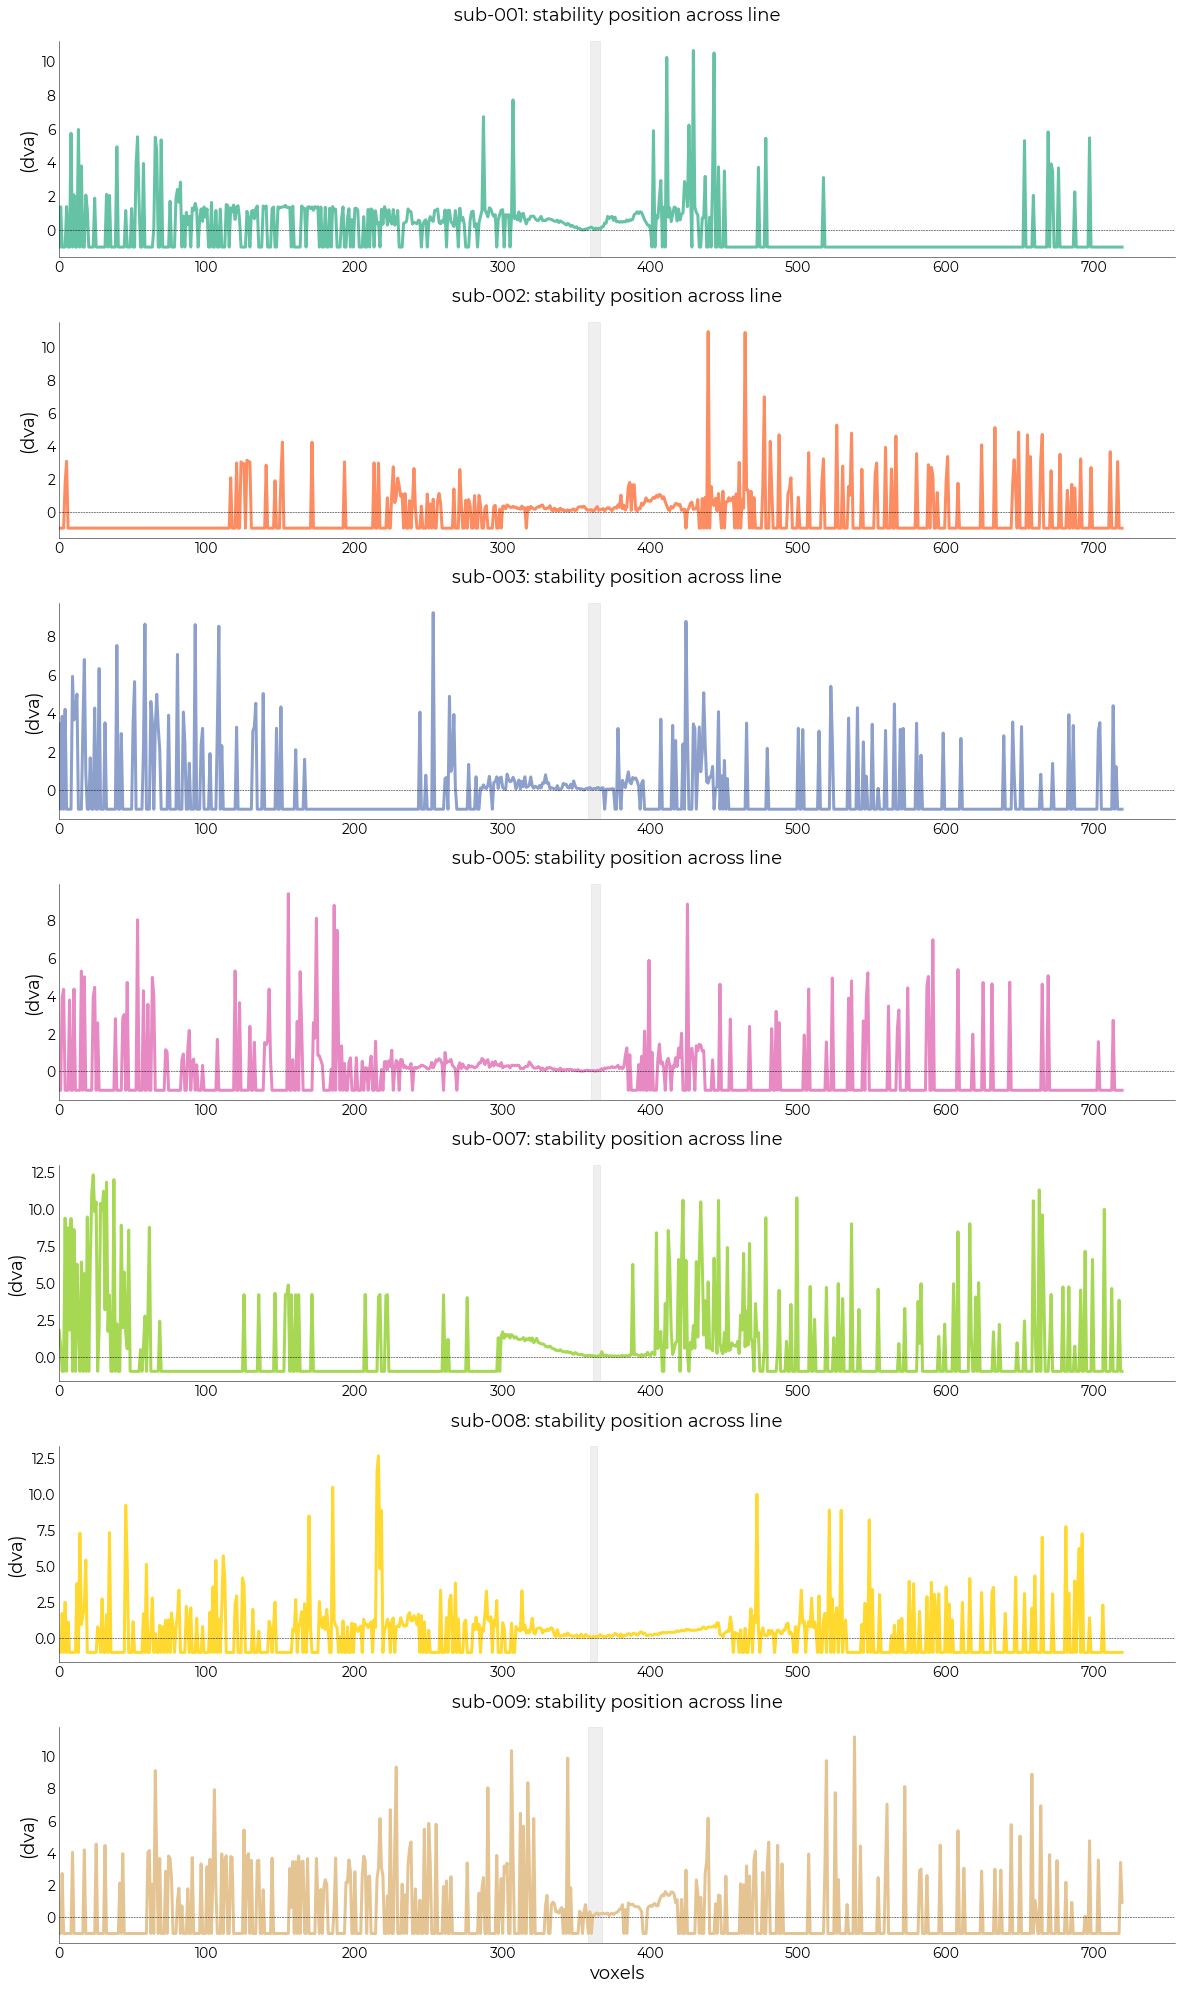

In [92]:
fig,axs = plt.subplots(
    nrows=len(subjects), 
    figsize=(20,5*len(subjects)),
    gridspec_kw={"hspace": 0.3})

for sub_ix,sub in enumerate(subjects):
    data = utils.select_from_df(diff_line, expression=f"subject = {sub}").reset_index()

    x_data = data["voxels"].values
    y_data = data["diff2avg"].values
    
    ax = axs[sub_ix]
    # plot ribbon area
    rib = subj_obj.get_ribbon(sub)
    print(f"{sub}: {rib}")
    ax.axvspan(
        *rib,
        color="#cccccc",
        alpha=0.3)

    if sub_ix != len(subjects)-1:
        x_lbl = None
    else:
        x_lbl = "voxels"

    plotting.LazyPlot(
        y_data,
        axs=ax,
        color=sub_colors[sub_ix],
        line_width=3,
        x_label=x_lbl,
        y_label="(dva)",
        title=f"{sub}: stability position across line",
        add_hline=0
    )


---
# Eyetracking

In [112]:
subj = "sub-001"
ses = subj_obj.get_session(subj)
log_dir = opj(base_dir, "sourcedata") #, subj, f"ses-{ses}")
edf_files = utils.FindFiles(log_dir, extension="edf").files
edf_files

sub_edfs = utils.get_file_from_substring([], edf_files, exclude="run-0")
sub_edfs

['/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-001/ses-2/sub-001_ses-2_task-pRF_run-2/sub-001_ses-2_task-pRF_run-2.edf',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-001/ses-2/sub-001_ses-2_task-pRF_run-3/sub-001_ses-2_task-pRF_run-3.edf',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-001/ses-2/sub-001_ses-2_task-pRF_run-4/sub-001_ses-2_task-pRF_run-4.edf',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-001/ses-2/sub-001_ses-2_task-pRF_run-5/sub-001_ses-2_task-pRF_run-5.edf',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-002/ses-2/sub-002_ses-2_task-pRF_run-1/sub-002_ses-2_task-pRF_run-1.edf',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-002/ses-2/sub-002_ses-2_task-pRF_run-2/sub-002_ses-2_task-pRF_run-2.edf',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/sourcedata/sub-002/ses-2/sub-002_ses-2_task-pRF_run-3/sub-002_ses-2_task-pRF_run-3.edf',
 '/data1/projects/Mi

In [113]:
eye_ = dataset.ParseEyetrackerFile(
    sub_edfs,
    use_bids=False,
    verbose=True
)


EYETRACKER
23-01-23_12-50-01 - INFO - EDFOperator - started with sub-001_ses-2_task-pRF_run-2.edf
23-01-23_12-50-01 - INFO - EDF2ASCOperator - <hedfpy.CommandLineOperator.EDF2ASCOperator object at 0x7f4270bf8a00> initialized with file sub-001_ses-2_task-pRF_run-2.edf
23-01-23_12-50-01 - INFO - EDFOperator - reading trials from sub-001_ses-2_task-pRF_run-2.msg
23-01-23_12-50-05 - INFO - EDFOperator - no parameter information in edf file
23-01-23_12-50-05 - INFO - EDFOperator - reading key_events from sub-001_ses-2_task-pRF_run-2.msg
23-01-23_12-50-08 - INFO - EDFOperator - reading key_events from sub-001_ses-2_task-pRF_run-2.msg
23-01-23_12-50-10 - INFO - EDFOperator - reading key_events from sub-001_ses-2_task-pRF_run-2.msg
23-01-23_12-50-12 - INFO - EDFOperator - reading eyelink events from sub-001_ses-2_task-pRF_run-2.msg
23-01-23_12-50-12 - INFO - EDFOperator - reading sounds from sub-001_ses-2_task-pRF_run-2.msg
23-01-23_12-50-12 - INFO - EDFOperator - cleaning gaze information fr

IndexError: list index out of range

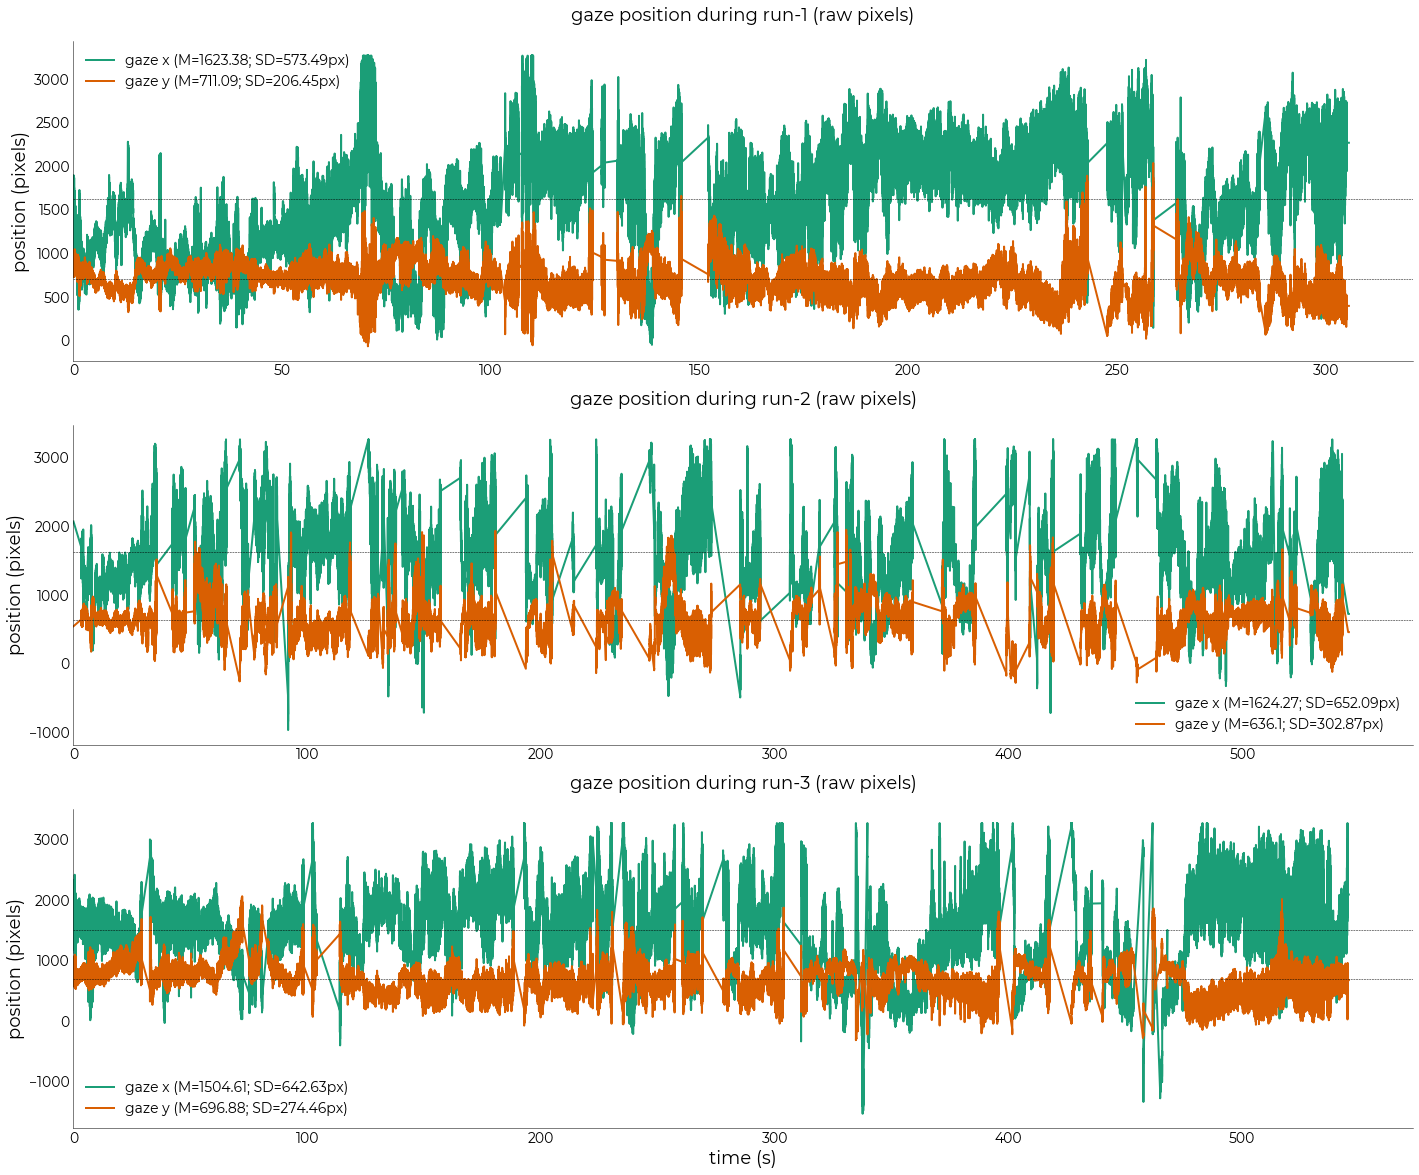

In [107]:
# gaze x/y
df_gaze = eye_.df_space_eye.copy()

fig,axs = plt.subplots(
    nrows=len(eye_.edf_file), 
    figsize=(24,20))

for ix,rr in enumerate(eye_.edf_file):
    
    if ix == len(eye_.edf_file)-1:
        x_lbl = "time (s)"
    else:
        x_lbl = None

    run = utils.split_bids_components(rr)["run"]
    df = utils.select_from_df(df_gaze, expression=f"run = {run}")

    input_l = [df[f"gaze_{i}_int"].values for i in ["x","y"]]
    avg = [float(input_l[i].mean()) for i in range(len(input_l))]
    std = [float(input_l[i].std()) for i in range(len(input_l))]
    
    # x-axis
    xx = list(np.arange(0,input_l[0].shape[0])*1/eye_.sample_rate)
    ax = axs[ix]
    plotting.LazyPlot(
        input_l,
        xx=xx,
        line_width=2,
        axs=ax,
        color=["#1B9E77","#D95F02"],
        labels=[f"gaze {i} (M={round(avg[ix],2)}; SD={round(std[ix],2)}px)" for ix,i in enumerate(["x","y"])],
        x_label=x_lbl,
        y_label="position (pixels)",
        add_hline={"pos": avg},
        title=f"gaze position during run-{run} (raw pixels)"
    )

fname = opj(fig_dir, subj, f"{subj}_desc-gaze_px")
for ext in ['png','svg']:
    utils.verbose(f"Writing {fname}.{ext}", verbose)
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

---
# pRF parameters across (deprecated for now)

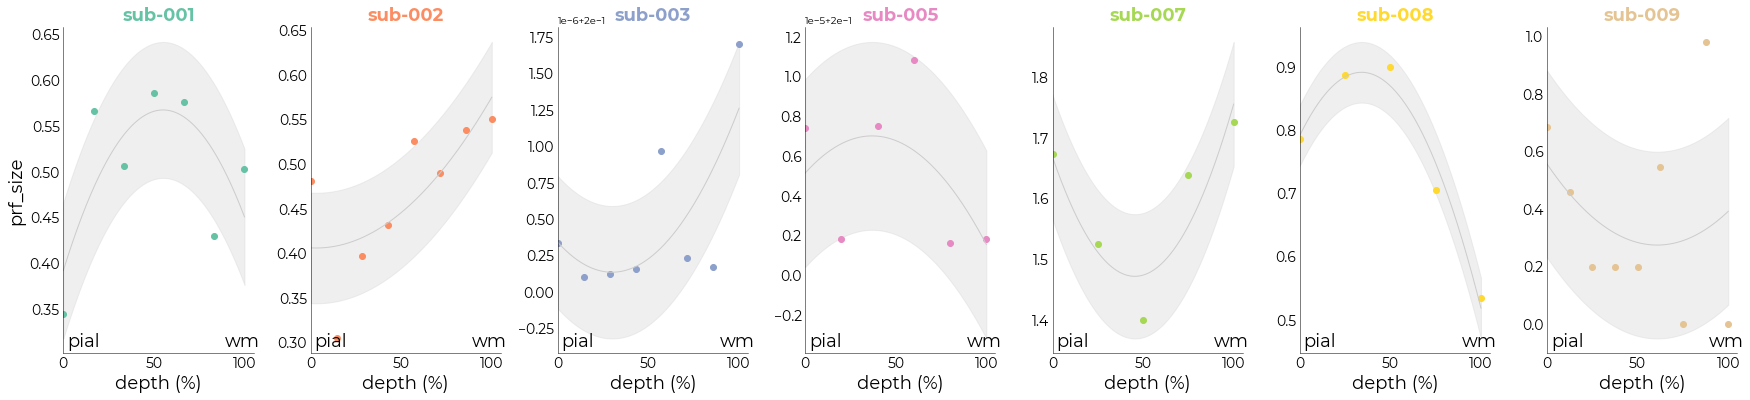

In [51]:
fit_order = 2

# initialize figure
fig = plt.figure(figsize=(30,6))
gs = fig.add_gridspec(ncols=len(subjects), wspace=0.3)

par = "prf_size"
for sub_ix,sub in enumerate(subjects):
    ax = fig.add_subplot(gs[sub_ix])

    # get subject-specific dataframe
    data = utils.select_from_df(params_depth, expression=f"subject = {sub}")

    # and depths
    depths = data.reset_index()["depth"].values

    for ix,dep in enumerate(depths):
        ax.plot(
            dep,
            data[par].iloc[ix], 
            "o", 
            color=sub_colors[sub_ix])

    yy = data[par].values
    cf = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=fit_order, 
        verbose=False)

    # plot fit
    if sub_ix == 0:
        y_lbl = par
    else:
        y_lbl = None

    pl = plotting.LazyPlot(
        cf.y_pred_upsampled,
        xx=cf.x_pred_upsampled,
        axs=ax,
        error=cf.ci_upsampled,
        color="#cccccc",
        x_label="depth (%)",
        x_ticks=[0,50,100],
        # y_lim=[-1,2],
        y_label=y_lbl)

    # pial
    ax.annotate(
        "pial", 
        (0.02,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

    # wm
    ax.annotate(
        "wm", 
        (0.85,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

    ax.set_title(sub, fontsize=18, color=sub_colors[sub_ix], fontweight="bold")

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_{par}")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )    

r2: AIC (lin) = -4.54, AIC (2nd) = -4.52
prf_size: AIC (lin) = 0.79, AIC (2nd) = 1.68
B: AIC (lin) = 3.88, AIC (2nd) = 5.86
D: AIC (lin) = 3.97, AIC (2nd) = 3.48


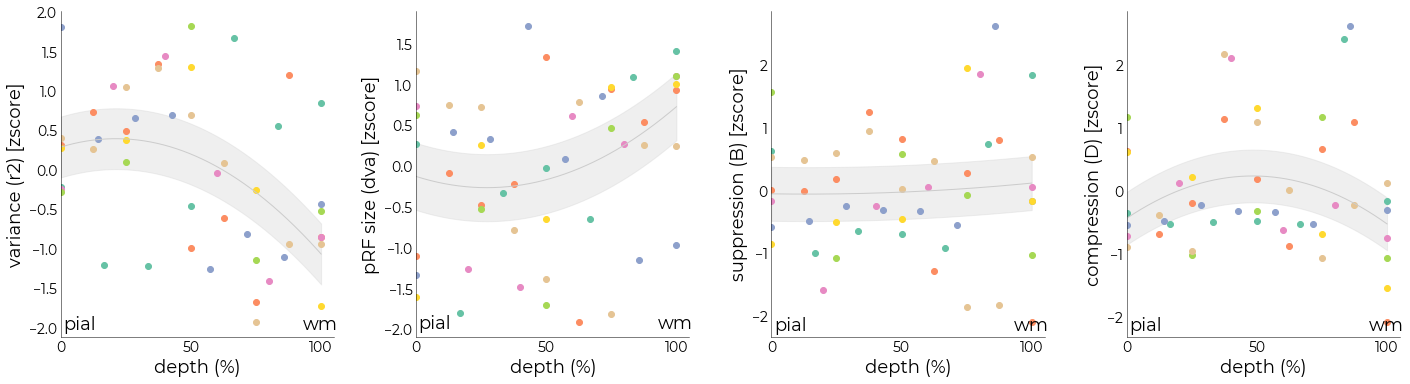

In [ ]:
# make list of parameters to include; should strings that are present as column names in dataframe above
include = ["r2","prf_size","B","D"]
fit_order = 2

# initialize figure
fig = plt.figure(figsize=(24,6))
gs = fig.add_gridspec(ncols=len(include), wspace=0.3)

aic_df = {}
aic_df["model"],aic_df["code"],aic_df["aic"],aic_df["par"] = [],[],[],[]

# loop through parameters
for par_ix,par in enumerate(include):
    
    # add axis to plot
    ax = fig.add_subplot(gs[par_ix])

    # prettify axis labels
    if par == "prf_size":
        x_label = "pRF size (dva) [zscore]"
    elif par == "A":
        x_label = "activation amplitude (A) [zscore]"
    elif par == "B":
        x_label = "suppression (B) [zscore]"
    elif par == "C":
        x_label = "normalization amplitude (C) [zscore]"
    elif par == "D":
        x_label = "compression (D) [zscore]"
    elif par == "r2":
        x_label = "variance (r2) [zscore]"
    else:
        x_label = f"{par} [zscore]"

    # for sub_ix,sub in enumerate(["sub-001","sub-002","sub-003","sub-007","sub-008"]):
    for sub_ix,sub in enumerate(subjects):

        # get subject-specific dataframe
        data = utils.select_from_df(params_depth, expression=f"subject = {sub}")

        # and depths
        depths = data.reset_index()["depth"].values

        for ix,dep in enumerate(depths):
            ax.plot(
                dep,
                data[par].iloc[ix], 
                "o", 
                color=sub_colors[sub_ix])

    # throw all subjects in CurveFitter
    if not isinstance(fit_order, int):
        if len(fit_order) != len(subjects):
            raise ValueError(f"Expected a list of length {len(include)} for fit orders, not {len(fit_order)}. Please specify an integer representing the fit order for all elements in {include} or a list of fit orders for each parameter")

        order = fit_order[par_ix]
    else:
        order = fit_order

    yy = params_depth.sort_values(['depth','subject'])[par].values
    
    # run linear model for AIC comparison
    cf_lin = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=1, 
        verbose=False)

    add_par = par
    if par == "prf_size":
        add_par = "size"

    aic_df["code"].append(0)
    aic_df["model"].append("linear")
    aic_df["aic"].append(cf_lin.result.aic)
    aic_df["par"].append(add_par)

    cf = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=order, 
        verbose=False)

    aic_df["code"].append(1)
    aic_df["model"].append("2nd order")
    aic_df["aic"].append(cf.result.aic)
    aic_df["par"].append(add_par)


    print(f"{par}: AIC (lin) = {round(cf_lin.result.aic,2)}, AIC (2nd) = {round(cf.result.aic,2)}")

    # plot fit
    pl = plotting.LazyPlot(
        cf.y_pred_upsampled,
        xx=cf.x_pred_upsampled,
        axs=ax,
        error=cf.ci_upsampled,
        color="#cccccc",
        x_label="depth (%)",
        x_ticks=[0,50,100],
        y_label=x_label)

    # pial
    ax.annotate(
        "pial", 
        (0.02,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

    # wm
    ax.annotate(
        "wm", 
        (0.85,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

aic_df = pd.DataFrame(aic_df)
fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_pars_scatter3")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

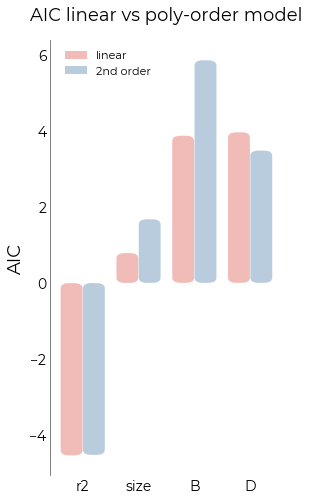

In [ ]:
fig,axs = plt.subplots(figsize=(4,8))

plotting.LazyBar(
    data=aic_df,
    x="par",
    y="aic",
    hue="model",
    sns_ori="v",
    sns_offset=5,
    axs=axs,
    add_labels=True, 
    y_label2="AIC",
    fancy=True,
    fancy_aspect=0.9,
    trim_bottom=True,
    error=None,
    add_legend=True,
    cmap="Pastel1",
    title2="AIC linear vs poly-order model"
)

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_aic")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

In [ ]:
data

x   y  prf_size  prf_ampl  bold_bsl  neur_bsl  surr_ampl  \
subject depth                                                              
sub-008 0.0   NaN NaN -1.597552  0.328125       NaN -0.849508   0.511573   
        25.0  NaN NaN  0.258185 -0.416644       NaN -0.492242  -0.144971   
        50.0  NaN NaN -0.643662  1.091903       NaN -0.444110   1.414735   
        75.0  NaN NaN  0.973300  0.727759       NaN  1.952211  -0.139264   
        100.0 NaN NaN  1.009729 -1.731143       NaN -0.166352  -1.642074   

               surr_size  surr_bsl         A         B         C         D  \
subject depth                                                                
sub-008 0.0    -1.642459       NaN  0.328125 -0.849508  0.511573  0.630048   
        25.0    0.991569       NaN -0.416644 -0.492242 -0.144971  0.232586   
        50.0    1.051592       NaN  1.091903 -0.444110  1.414735  1.332119   
        75.0    0.057519       NaN  0.727759  1.952211 -0.139264 -0.669631   
        100.0  -0.458220       NaN -1.731143 -0.166352 -1.642074 -1.525122   

               ratio (B/D)        r2  size ratio  suppression index  ecc  \
subject depth                                                              
sub-008 0.0      -0.622082  0.280643    0.403890           0.520987  NaN   
        25.0     -0.547010  0.387475    0.388923           0.378869  NaN   
        50.0     -0.688754  1.313339    1.449324           1.327477  NaN   
        75.0     -0.099089 -0.254808   -0.932020          -0.699948  NaN   
        100.0     1.956935 -1.726649   -1.310118          -1.527386  NaN   

               polar  
subject depth         
sub-008 0.0      NaN  
        25.0     NaN  
        50.0     NaN  
        75.0     NaN  
        100.0    NaN

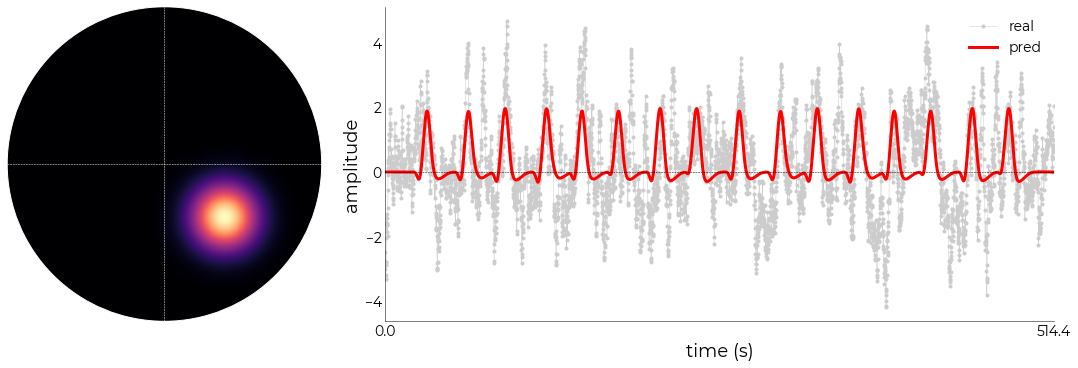

In [ ]:
_,_,tc,_ = full_dict["sub-001"]['lines']['ribbon'].plot_vox(
    vox_nr=1,
    model=model,
    stage='iter'
)

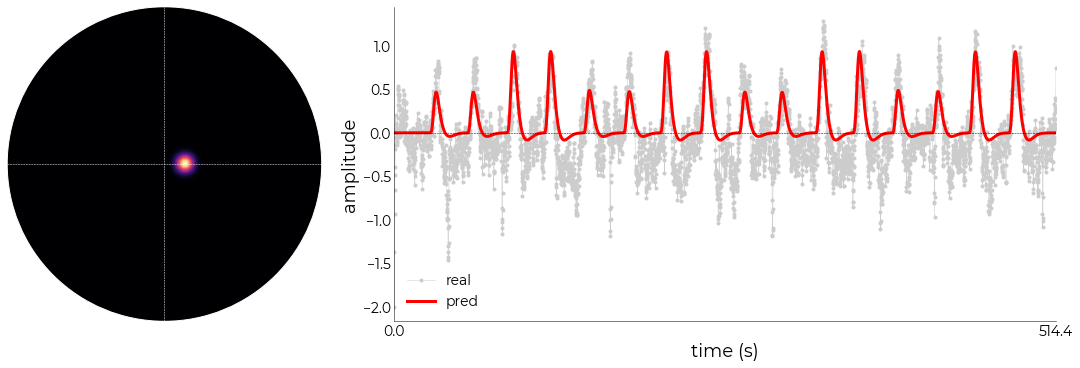

In [224]:
_,_,tc,_ = full_dict["sub-005"]['lines']['avg'].plot_vox(
    model=model,
    stage='iter'
)

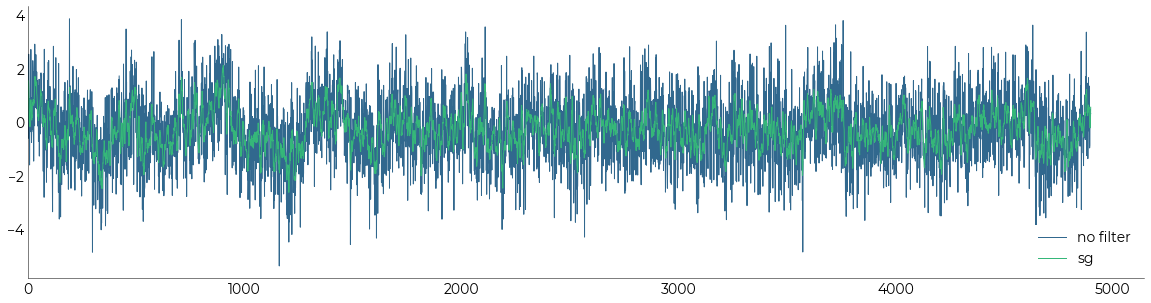

In [ ]:
from linescanning import preproc
tc_sg = preproc.lowpass_savgol(tc, window_length=13, polyorder=3)

plotting.LazyPlot(
    [tc,tc_sg],
    labels=["no filter","sg"],
    figsize=(20,5)
)